<p align="center">
  <img src="https://www.proteste.org.br/-/media/proteste/images/home/seus%20direitos/direitos%20do%20consumidor/atraso-na-entrega.png?rev=5a293bcb-ef99-4ffd-ad2b-0a3548b1654e" alt="drawing" width="600" height="400"/>


</p>


## Sumário

1. Modelo final para a previsão de pedidos em atraso
2. Importando as bibliotecas
3. Configurações adicionais
4. Dados utilizados
5. Pré-processamento dos dados
6. Separação entre treino e teste
7. Random Forest (RF)
8. Métricas
9. Validação Cruzada
10. Importância das variáveis


# 1. Modelo final para a previsão de pedidos em atraso

---

No [notebook](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb) passado abordamos os seguintes tópicos:

- Explicação da competição da iNeuron: objetivo, métricas, premiação (não se esqueçam, esses projetos são focados na **aprendizagem** e não em ganhar a competição);
- Quais métricas utilizar para nossos dados;
- Criar uma baseline com o modelo de regressão logística sem a nenhum tipo de pré-processamento nos dados;
- Verificar a situação que temos nos dados;
- Aplicar uma Análise Exploratória de Dados completa;

Recomendo fortemente olhar o notebook anterior pois bastante coisa que tem neste será tratada de forma direta. É isto, vamos melhorar nosso modelo anterior (baseline).

# 2. Importando as bibliotecas

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3. Configurações adicionais

---



In [ ]:
plt.style.use("seaborn-muted")
%matplotlib inline
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount("/content/drive", force_remount = True)

# 4. Dados utilizados

---

Para não ficar muito sem nexo, algumas informações do banco de dados estão abaixo. 

## 4.1. Carregando o banco de dados

In [ ]:
banco = pd.read_csv("/content/drive/My Drive/Training_Dataset_v2.csv", low_memory = False)

## 4.2. Dicionário das variáveis

1. sku – Random ID for the product
2. national_inv – Current inventory level for the part
3. lead_time – Transit time for product (if available)
4. in_transit_qty – Amount of product in transit from source
5. forecast_3_month – Forecast sales for the next 3 months
6. forecast_6_month – Forecast sales for the next 6 months
7. forecast_9_month – Forecast sales for the next 9 months
8. sales_1_month – Sales quantity for the prior 1 month time period
9. sales_3_month – Sales quantity for the prior 3 month time period
10. sales_6_month – Sales quantity for the prior 6 month time period
11. sales_9_month – Sales quantity for the prior 9 month time period
12. min_bank – Minimum recommend amount to stock
13. potential_issue – Source issue for part identified
14. pieces_past_due – Parts overdue from source
15. perf_6_month_avg – Source performance for prior 6 month period
16. perf_12_month_avg – Source performance for prior 12 month period
17. local_bo_qty – Amount of stock orders overdue
18. deck_risk – Part risk flag
19. oe_constraint – Part risk flag
20. ppap_risk – Part risk flag
21. stop_auto_buy – Part risk flag
22. rev_stop – Part risk flag
23. went_on_backorder – Product actually went on backorder. This is the target value.

## 4.3. Estrutura

---



In [ ]:
banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

## 4.4. Sumário estatístico das variáveis

In [ ]:
banco.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.11,29615.23,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.87,7.06,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.05,1342.74,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.12,5026.55,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.99,9795.15,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.36,14378.92,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.93,1928.20,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.03,5192.38,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.73,9613.17,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.27,14838.61,0.0,0.00,4.00,47.00,3205172.0


## 5. Pré-processamento dos dados

---

Agora é a hora que ~o filho chora e a mãe não vê~, a partir da análise exploratória e de alguns insights retirados do notebook anterior, iremos fazer uma série de transformações nas variáveis.

## 5.1. Exclusão de variáveis

Somente uma, que nesse caso é a **sku**, somente um ID randômico dos produtos. Não faria sentido deixar ela no modelo.

In [ ]:
banco = banco.drop("sku", axis = 1)

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


## 5.2. Tratamento de valores nulos

Como podemos observar que: 

- Todas as variáveis possuem pelo menos um valor nulo;

-  A variável **lead_time** (transit time for product (if available)) possui 100.894 valores nulos.

In [ ]:
banco.isnull().sum()

national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

Investigando a tabela abaixo, temos:

- Podemos observar que a última observação contém valores nulos para todas as variáveis. 
- Logo, devemos excluir ela;
- E a variável **lead_time**, com essa exclusão, passa a ter 100.893 valores nulos.

In [ ]:
banco[banco.isnull().any(axis = 1)]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
6,1095.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,No,0.0,-99.0,-99.0,0.0,Yes,No,No,Yes,No,No
8,140.0,NaN,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.0,-99.0,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687835,227.0,NaN,8.0,0.0,0.0,0.0,19.0,78.0,205.0,289.0,59.0,No,0.0,-99.0,-99.0,1.0,No,No,Yes,No,No,No
1687847,-206.0,NaN,0.0,760.0,1145.0,1453.0,114.0,853.0,1764.0,2706.0,0.0,No,0.0,-99.0,-99.0,206.0,Yes,No,No,Yes,No,No
1687850,-2.0,NaN,0.0,0.0,62.0,86.0,6.0,32.0,46.0,57.0,2.0,No,0.0,-99.0,-99.0,32.0,Yes,No,No,No,No,No
1687856,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.0,-99.0,1.0,No,No,No,Yes,No,No


In [ ]:
banco = banco[: -1]

banco.tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687855,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,No,0.0,0.69,0.69,5.0,Yes,No,No,Yes,No,No
1687856,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


- A variável **lead_time** nos diz respeito ao tempo de trânsito do produto (quando disponível). Fiz os seguintes testes para lidar com os valores nulos

  - Imputar a média: "Vale a pena imputar o tempo médio de trânsito ?"
  - Imputar a mediana: "Vale a pena imputar o tempo que corresponde a 50% dos pedidos em trânsito ?"
  - Imputar a moda: "Vale a pena imputar o valor mais frequente ?"
  - Substituir por um valor fora do padrão da variável.

- O método que apresentou mais eficácia nos testes foi substituir por um valor fora do padrão da variável, indicando que os valores nulos desta variável são justamente os tempos dos produtos que não estão disponíveis (são omissos). 

- Existem **N** valores para se colocar para indicar um ponto fora do padrão para o modelo, nesse caso, eu substituí os valores pelo 999.

In [ ]:
banco["lead_time"] = banco["lead_time"].fillna(999)

## 5.3. Codificando as variáveis que possuem categorias "Sim" e "Não"

- Essa codificação é necessária para entrar no modelo, pois os modelos do `sklearn` pedem que as categorias das variáveis categóricas sejam números e não caracteres;

- As variáveis que foram transformadas são:

  1. potential_issue;
  2. deck_risk;
  3. oe_constraint;
  4. ppap_risk;
  5. stop_auto_buy;
  6. rev_stop;
  7. went_on_backorder.

- A transformação foi:

  - Categoria "não": 0
  - Categoria "sim": 1

In [ ]:
columns_yesno = ["potential_issue", "deck_risk", "oe_constraint", "ppap_risk", "stop_auto_buy", "rev_stop", "went_on_backorder"]

banco[columns_yesno] = banco[columns_yesno].replace({"No" : 0, "Yes": 1})

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0


## 5.4. Criando novas features para o modelo

- Agora vem a parte legal, talvez umas das mais interessantes de toda a parte da modelagem;

- Temos que conhecer da área de negócio em que estamos envolvidos para a construção do projeto/modelo;

- Mas também, dependendo do caso, podemos criar features aleatórias para melhorar a métrica do nosso modelo (Alô, Kaggle);

- Algumas das ideias foram retiradas a partir da Análise Exploratória de Dados do notebook anterior, que está neste [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file);

- Ao fim do notebook, irei deixar o link para os notebooks em que testei exaustivamente features úteis e inúteis que, ao final, deram valor ao modelo.

### 5.4.1. Polinômios das variáveis

- Aqui eu testei algumas variáveis elevadas ao quadrado e ao cubo;

- Dessa transformação, a variável que mais foi útil nos testes foi o quadrado da **national_inv**;

- Isto é, o quadrado do **Nível de Estoque Atual da Peça** foi uma boa variável para o modelo;

- Note que o segundo gráfico mostra a distribuição da variável para cada uma das categorias, apesar da diferença de escalas (desculpe ao leitor, tentei de todo o jeito criar algo comparável, log, etc.), pode-se observar que há uma diferença nos locais em que as variáveis tem seus picos e, sendo assim, ela pode ser uma boa variável para separar corretamente uma categoria da outra;

- Como o banco de dados provêm de uma competição, em que pode ter dados anônimos, sintéticos, não consigo mensurar para vocês a interpretação exata dessa variável;

- Se alguém da área ler isto e puder nos explicar a relação, ficaria agradecido e faço o esforço de editar esse notebook posteriormente com a explicação.


In [ ]:
banco["national_inv_poly2"] = banco["national_inv"] ** 2


banco["national_inv_poly2"].describe().apply(lambda x: "%.2f" % x)

count            1687860.00
mean           877307682.12
std         317807565195.13
min                    0.00
25%                   16.00
50%                  225.00
75%                 6400.00
max      152137522035216.00
Name: national_inv_poly2, dtype: object

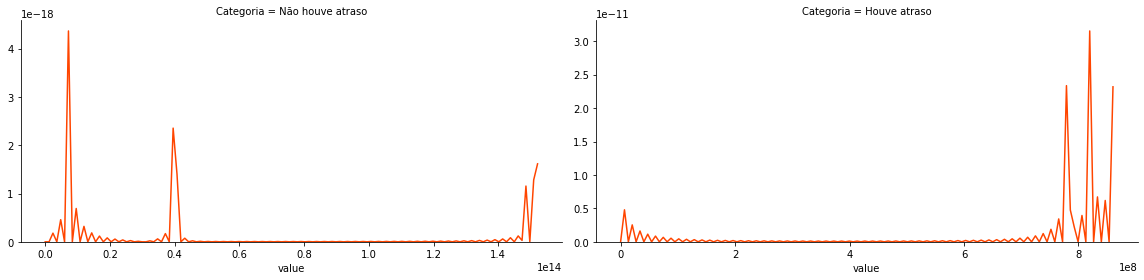

In [ ]:
x = banco[banco["went_on_backorder"] == 0]["national_inv_poly2"]
y = banco[banco["went_on_backorder"] == 1]["national_inv_poly2"]

df = pd.concat([x, y], axis = 1)
df.columns = ["Não houve atraso", 'Houve atraso']
df = pd.melt(df, var_name = "Categoria")

g = sns.FacetGrid(df, col = "Categoria", col_wrap = 2, sharex = False, sharey = False, height = 4, aspect = 2)
g = g.map(sns.distplot, "value", color = "orangered", hist = False)

## 5.4.2. Categorização da variável national_inv

- Pelo que vimos anteriormente, esta variável indica o __Nível de Estoque Atual da Peça__ e ela possui valores positivos ou negativos;

- A variável criada foi justamente para saber se o nível de estoque daquele $ X_i $ produto é negativo/igual a zero ou positivo;

  - 0 se $ X_i $ <= 0;
  - 1 se $ X_i $ > 0.

- Ela será armazenada em uma variável chamada `national_inv_qual`;

- Quando relacionamos ela com a variável `went_on_backorder` (houve ou não atras), pode-se observar que a maioria das observações se concentra na categoria em que o nível de estoque do produto é positivo e em que não houve atraso para o produto.


In [ ]:
banco["national_inv_qual"] = banco["national_inv"].apply(lambda x: 0 if x <= 0 else 1)

banco.groupby(["national_inv_qual", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,national_inv_qual,went_on_backorder,Quantidade
0,0,0,109470
1,0,1,4843
2,1,0,1567097
3,1,1,6450


### 5.4.3. Verificando se a variável lead_time é nula

- Essa entrou por meio dos testes;

- Como vimos anteriormente, os valores nulos nesta variável indicam que os tempos de entrega para estes produtos não estão disponíveis;

- Com base nisso, criamos uma feature justamente para indicar de outra forma: "Olha, esse valor não está disponível". Algo como um segundo indicador de observações não disponíveis para esta variável;

- Como ela é baseada na variável que fizemos uma transformação, temos

  - 0, se a variável `lead_time` não for 999;
  - 1, se a variável `lead_time` for 999;

- A maioria dos valores se concentram quando o tempo de entrega para os produtos não é nulo e quando o pedido não atrasou;

In [ ]:
banco["lead_time_isnull"] = banco["lead_time"].map(lambda x: 1 if x == 999 else 0)

banco.groupby(["lead_time_isnull", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,lead_time_isnull,went_on_backorder,Quantidade
0,0,0,1575998
1,0,1,10969
2,1,0,100569
3,1,1,324


### 5.4.4. Relação `min_bank` e `national_inv`

- Por meio da correlação linear de Pearson entre essas variáveis, ver este [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.2.-Explorando-as-vari%C3%A1veis-quantitativas), verificamos que quanto maior o nível de estoque atual da peça, maior a quantidade mínima do produto recomendada para ficar em estoque;

- Neste [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.6.-Explorando-as-rela%C3%A7%C3%B5es-entre-vari%C3%A1veis-(hip%C3%B3teses)), que dá acesso ao notebook anterior, podemos ver que essa é uma das hipóteses, confirmando que há uma possível relação entre elas;

- Logo, pensei em criar uma relação entre elas, nesse caso, uma razão. E a partir dessa razão, um indicador verificando se essa relação vai ser positiva/igual a zero ou negativa

  - 0, se $ X_i $ < 0
  - 1, se $ X_i $ >= 0

- A maioria dos valores se concentra na categoria em que esta relação é positiva/igual a zero e em que não houve atraso para os produtos.


In [ ]:
banco["relat_minbank_nationalinv"] = banco["min_bank"]/banco["national_inv"]
banco["relat_minbank_nationalinv"] = banco["relat_minbank_nationalinv"].apply(lambda x: 0 if x < 0 else 1)


banco.groupby(["relat_minbank_nationalinv", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,relat_minbank_nationalinv,went_on_backorder,Quantidade
0,0,0,3855
1,0,1,689
2,1,0,1672712
3,1,1,10604


### 5.4.4. Quartis das variáveis que possuem alta variação

- Como podemos observar através desta [tabela](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file) descritiva, no notebook anterior, podemos perceber que as variáveis **national_inv**, **in_transit_qty**, **min_bank**, **national_inv_poly2** possuem alta variação;

- Note também que os quartis são valores bastante atípicos, dados os seus valores máximos e mínimos;

- A partir disso, criamos novas features a partir destas variáveis justamente para verificar se o modelo consegue achar um padrão, principalmente na categoria "Houve atraso no produto";

- Podemos notar que para a feature `in_transit_qty_new` toda a distribuição ficou somente em uma categoria, logo, será retirada do banco de dados;

- As demais serão inclusas no modelo e no banco de dados por meio de variávais dummies (se você não sabe o que é uma variável dummy, não se preocupe irei deixar um artigo explicando melhor o que é ~espero me lembrar de colocar no final~);

In [ ]:
colunas = ["national_inv", "in_transit_qty", "min_bank", "national_inv_poly2"]
novas_colunas = [i + "_new" for i in colunas]
banco[novas_colunas] = banco[colunas].apply(lambda x: pd.qcut(x, 4, duplicates = "drop"), axis = 0)

banco = banco.drop("in_transit_qty_new", axis = 1)
novas_colunas.remove("in_transit_qty_new")

for coluna in banco[novas_colunas]:

  print("#--- Variável: ", coluna, "\n", 15*"---", "\n", sep = "")
    
  print(banco[coluna].value_counts(normalize = True).mul(100).round(2))
  
  print(15*"---")

#--- Variável: national_inv_new
---------------------------------------------

(-27256.001, 4.0]     26.14
(80.0, 12334404.0]    24.94
(4.0, 15.0]           24.90
(15.0, 80.0]          24.02
Name: national_inv_new, dtype: float64
---------------------------------------------
#--- Variável: min_bank_new
---------------------------------------------

(-0.001, 3.0]      75.47
(3.0, 313319.0]    24.53
Name: min_bank_new, dtype: float64
---------------------------------------------
#--- Variável: national_inv_poly2_new
---------------------------------------------

(-0.001, 16.0]                 25.94
(6400.0, 152137522035216.0]    24.99
(16.0, 225.0]                  24.97
(225.0, 6400.0]                24.09
Name: national_inv_poly2_new, dtype: float64
---------------------------------------------


### 5.4.5. É maior que o X percentil ?

- Em diversos momentos da [Análise Exploratória de Dados](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file), percebi que algumas variáveis diferem muito em quartis, se você leitor poder novamente verificar os quartis das variáveis abaixo verá do que estou falando;

- Esse problema nos quartis, me levou a seguinte pergunta: "Esse produto existe mesmo ?";

- Dado esse problema, pensei na seguinte solução: "Se o produto realmente existe, então ele tem que estar acima de X quartil";

- A partir dessa ideia, criei uma função para verificar se o $ X_i $ produtos, para as variáveis a seguir, está acima de um Z percentil;

- A partir de alguns testes, verifiquei que o percentil que melhor perfomou para os dados foi o de 85;

- A regra de decisão é, para cada variável:

  - Se $ X_i < 0 $, então 0;
  - Se $ X_i \geq 0 $, então 1.

- Assim como grande parte dos programadores, eu também não sou a pessoa mais criativa para dar nome de variáveis, espero que você me entenda, leitor.

In [ ]:
ideia1 = ["national_inv", "in_transit_qty", "min_bank", "forecast_3_month", "forecast_6_month", "forecast_9_month",
          "sales_1_month", "sales_3_month", "sales_6_month", "sales_9_month"]


def isabovequant(df, quantile):

  for column in df:

    novas_colunas1 = column + '_isabove_quantile'

    selec_quantile = banco[column].quantile(q = quantile)

    banco[novas_colunas1] = banco[column].apply(lambda x: 1 if x >= selec_quantile else 0)


isabovequant(df = banco[ideia1], quantile = 0.85) 
banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,national_inv_poly2,national_inv_qual,lead_time_isnull,relat_minbank_nationalinv,national_inv_new,min_bank_new,national_inv_poly2_new,national_inv_isabove_quantile,in_transit_qty_isabove_quantile,min_bank_isabove_quantile,forecast_3_month_isabove_quantile,forecast_6_month_isabove_quantile,forecast_9_month_isabove_quantile,sales_1_month_isabove_quantile,sales_3_month_isabove_quantile,sales_6_month_isabove_quantile,sales_9_month_isabove_quantile
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0,0.0,0,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0,4.0,1,0,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,4.0,1,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0,49.0,1,0,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,64.0,1,1,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0


### 5.4.6. As variáveis tem $ X_i $ valores iguais a 0 ?

- Ainda por meio da [Análise Exploratória de Dados](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#4.1.-Task-1:-Do-a-complete-EDA-in-the-python-notebook-file), verifica-se que muitos valores destas variáveis são iguais a 0;

- As variáveis que apresentam esse padrão são forecast_3_month e sales_1_month. E a regra de decisão é

  - 0, se $ X_i \neq 0 $;
  - 1, se $ X_i = 0 $ 

In [ ]:
var1 = ["forecast_3_month", "sales_1_month"]
var2 = [i + "_isesqual0" for i in var1]


banco[var2] = banco[var1].applymap(lambda x: 1 if x == 0 else 0)

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,national_inv_poly2,national_inv_qual,lead_time_isnull,relat_minbank_nationalinv,national_inv_new,min_bank_new,national_inv_poly2_new,national_inv_isabove_quantile,in_transit_qty_isabove_quantile,min_bank_isabove_quantile,forecast_3_month_isabove_quantile,forecast_6_month_isabove_quantile,forecast_9_month_isabove_quantile,sales_1_month_isabove_quantile,sales_3_month_isabove_quantile,sales_6_month_isabove_quantile,sales_9_month_isabove_quantile,forecast_3_month_isesqual0,sales_1_month_isesqual0
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0,0.0,0,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0,4.0,1,0,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,4.0,1,1,1,"(-27256.001, 4.0]","(-0.001, 3.0]","(-0.001, 16.0]",0,0,0,0,0,0,0,0,0,0,1,1
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0,49.0,1,0,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0,1,1
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,64.0,1,1,1,"(4.0, 15.0]","(-0.001, 3.0]","(16.0, 225.0]",0,0,0,0,0,0,0,0,0,0,1,1


### 5.4.7. A performance do local de venda do produto é positivo ?

- Sinceramente, façam muito bem sua Análise Exploratória de Dados, é bastante importante para retirar essas ideias;

- Percebi também que a performance nos meses 6 e 12 possuíam valores negativos;

- A partir disto, criamos um indicador para verificar se esse valor é positivo ou não, com a seguinte regra de decisão:

  - 0: se $ X_i \leq 0 $;
  - 1: se $ X_i > 0 $;

- Podemos verificar que a maioria dos valores se encaixa na categoria em que o valor da variável de performance foi positivo e em que não houve atraso no produto.

In [ ]:
banco["perf_6_month_avg_isabove0"] = banco["perf_6_month_avg"].apply(lambda x: 1 if x <= 0 else 0)

banco.groupby(["perf_6_month_avg_isabove0", "went_on_backorder"]).size().reset_index().rename(columns = {0: "Quantidade"})

,perf_6_month_avg_isabove0,went_on_backorder,Quantidade
0,0,0,1509081
1,0,1,10288
2,1,0,167486
3,1,1,1005


### 5.4.8. Relação `national_inv_qual` x `forecast_3_month` ?

- Perceba que estou utilizando somente uma variável das que possuem N meses, pois as outras acicma dela são valores acumulados;

- Esta variável foi criada a partir dos resultados que estava tendo para todos os modelos que estava testando, elas são importantes para a separação das categorias de nossa variável target: "Houve atraso" e "Não houve atraso";

- Ela relaciona a categorização da variável que indica o **nível de estoque da peça** (**0** se os valores são negativos ou igual a 0 e **1** se positivo) com a previsão de vendas do produto para os próximos 3 meses;

- A relação é dada por $ (1 - national\_inv\_qual) \times forecast\_3\_month $

  - Quando a national_inv_qual é 0, os valores da `forecast_3_month` são assumidos para esta variável;

  - Quando a national_inv_qual é 1, os valores para essa variável serão 0.

- Essa feature nos mostra a relação entre os valores negativos ou iguais a 0 do nível de estoque dos produtos com a previsão de vendas de 3 meses para eles;

- Perceba no gráfico abaixo que a região da categoria "Não houve atraso" abrange valores maiores (eixo X), quando comparada com outra categoria (esperemos que nosso modelo entenda esse padrão);

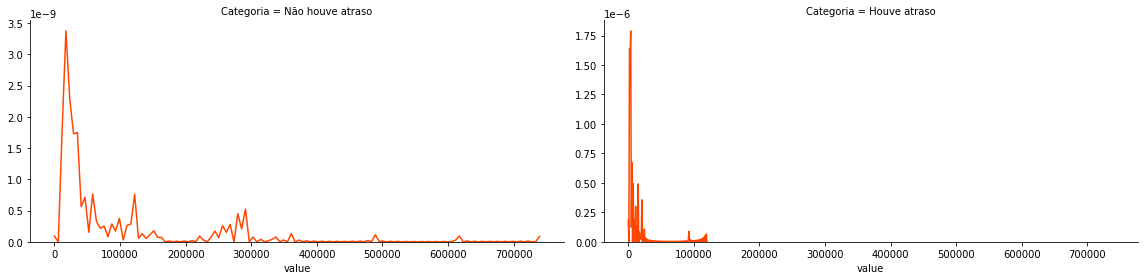

In [ ]:
banco["relat_nationalinvqual_forecast3"] = (1 - banco["national_inv_qual"]) * banco["forecast_3_month"]

x = banco[banco["went_on_backorder"] == 0]["relat_nationalinvqual_forecast3"]
y = banco[banco["went_on_backorder"] == 1]["relat_nationalinvqual_forecast3"]

df = pd.concat([x, y], axis = 1)
df.columns = ["Não houve atraso", 'Houve atraso']
df = pd.melt(df, var_name = "Categoria")

g = sns.FacetGrid(df, col = "Categoria", col_wrap = 2, sharex = True, sharey = False, height = 4, aspect = 2)
g = g.map(sns.distplot, "value", color = "orangered", hist = False)

## 5.5. One Hot Encoding (OHE) nas variáveis categóricas

- É uma técnica de pré-processamento utilizada para quando queremos adicionar variáveis que possuem mais de duas categorias ao modelo (*e.g* raça, cores, etc.);

- Resumindo (**irei deixar alguns links ao final para quem gostaria de entender melhor sobre**), ela cria *k* novas variáveis a partir das categorias de sua variável indicando se para cada k categoria existe ou não (0 ou 1) o valor na observação $ X_i $;

- **Exemplo:** Variável cor, elas podem assumir 5 categorias (azul, vermelho, verde, branca e preta). Quando aplicamos o OHE nessa variável, ela irá criar 5 novas variáveis (`cor_azul`, `cor_vermelha`, `cor_verde`, `cor_branca` e `cor_preta`). E na nossa primeira observação em que a variável possui categoria azul, vai ter o valor **1** na variável `cor_azul` e para as demais **0**, e assim por diante para as demais observações;

- No caso, temos as variáveis categóricas armazenadas na variável `novas_colunas` e utilizaremos o `get_dummies` do pandas para fazer essa transformação;

  - O parâmetro `drop_firt = True` retira a variável principal (no nosso exemplo seria a que nos dá a informação das cores) que ficaria no banco;

- Se você, leitor, saber um jeito de utilizar o OHE do `sklearn` e já fazer o `assign` desse OHE diretamente no banco de dados, favor, me contatar pois já ouvi falar de alguns problemas do `get_dummies`;

In [ ]:
banco = pd.get_dummies(data = banco, columns = novas_colunas,  drop_first = True)

banco.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,national_inv_poly2,national_inv_qual,lead_time_isnull,relat_minbank_nationalinv,national_inv_isabove_quantile,in_transit_qty_isabove_quantile,min_bank_isabove_quantile,forecast_3_month_isabove_quantile,forecast_6_month_isabove_quantile,forecast_9_month_isabove_quantile,sales_1_month_isabove_quantile,sales_3_month_isabove_quantile,sales_6_month_isabove_quantile,sales_9_month_isabove_quantile,forecast_3_month_isesqual0,sales_1_month_isesqual0,perf_6_month_avg_isabove0,relat_nationalinvqual_forecast3,"national_inv_new_(4.0, 15.0]","national_inv_new_(15.0, 80.0]","national_inv_new_(80.0, 12334404.0]","min_bank_new_(3.0, 313319.0]","national_inv_poly2_new_(16.0, 225.0]","national_inv_poly2_new_(225.0, 6400.0]","national_inv_poly2_new_(6400.0, 152137522035216.0]"
0,0.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.0,0,0,0,0,0,0,0
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0,4.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0,0,0,0,0,0,0
2,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,4.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.0,0,0,0,0,0,0,0
3,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.10,0.13,0.0,0,0,0,1,0,0,49.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,1,0,0,0,1,0,0
4,8.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0,64.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.0,1,0,0,0,1,0,0


# 6. Separação entre treino e teste

---

- Vamos seguir com o mesmo esquema da nossa baseline, logo será destinado 70% dos dados aleatoriamente proporcional à variável `went_on_backorder` e 30% dos dados também aleatoriamente proporcional à mesma variável;

- Foi escolhido essa estratégia pois é uma grande massa de dados para o modelo treinar e também para testar;

- Fora que queremos ver se o nosso modelo é consistente em diferentes cenários (se você pensou em Validação Cruzada, acertou. Será simples, I promise);





In [ ]:
from sklearn.model_selection import train_test_split

x = banco.drop("went_on_backorder", axis = 1)
y = banco["went_on_backorder"]


x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, train_size = 0.7, random_state = 1234, stratify = y)


print(15*"---")
print("Dimensões dos dados de treino e teste:")
print(x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape)

print(15*"---")
print("Proporção da variável target nos dados de treino:\n", y_treino.value_counts(normalize = True))

print(15*"---")
print("Proporção da variável target nos dados de teste:\n", y_teste.value_counts(normalize = True))

---------------------------------------------
Dimensões dos dados de treino e teste:
(1181502, 46) (1181502,) (506358, 46) (506358,)
---------------------------------------------
Proporção da variável target nos dados de treino:
 0    0.993309
1    0.006691
Name: went_on_backorder, dtype: float64
---------------------------------------------
Proporção da variável target nos dados de teste:
 0    0.993309
1    0.006691
Name: went_on_backorder, dtype: float64


# 7. Random Forest (RF)

---


<p align="center">
  <img src="https://miro.medium.com/max/592/1*i0o8mjFfCn-uD79-F1Cqkw.png" alt="drawing" width="600" height="400"/>


Retirado de: https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
</p>


- Cá estamos, depois de todas as investigações nos dados, criações de features, pré-processamento, etc;

- **Pergunta:** "Ah, mas por quê uma Random Forest e não uma rede neural ?"

- **Resposta 1:** Depois de testes com regressão logística, árvore de decisão e SVM, que são os modelos que eu consigo explicar em um projeto como esse, por exemplo, verifiquei que esse foi o modelo que obteve as melhores métricas;

- As tentativas destes modelos com diversos parâmetros testados se encontram nesse [repositório](https://github.com/barbosarafael/Projetos/tree/master/iNeuron_Back_order_prediction_Notebook) do github;

- **Resposta 2:** Sou estudante e ainda não cheguei nesses modelos mais pesados/complexos :)

---

## 7.1. Um breve resumo de como funciona a Random Forest


- É um modelo de aprendizagem supervisionada que serve tanto para regressão quanto classificação;

- Ela é um método de **ensemble learning**, pois utiliza a estratégia de criar pequenas árvores individuais descorrelacionadas para combinar as predições e obter um melhor resultado (**bagging**); 

- Para que não haja sobreposição de variáveis para as diferentes árvores, isto é, para que as árvores não vejam as mesmas variáveis toda hora, é utilizado a técnica de **bootstraping**, ela constrói várias cópias dos dados esperando que essas novas amostras sejam da mesma distribuição que os dados originais;

- "Ah, mas qual categoria da variável target ela vai escolher ?"


<p align="center">
  <img src="https://i.pinimg.com/564x/0d/21/87/0d2187ce87b1aeff707f06f91d540522.jpg" alt="drawing" width="400" height="300"/>


Retirado de: https://br.pinterest.com/pin/304133781088821552/
</p>


- Segundo Morettin e Singer (2020), para uma nova observação do conjunto de teste, considere a categoria prevista das **N** árvores do modelo, e o rótulo para esta categoria será a maior ocorrência comum entre as **N** árvores, isto é, o voto majoritário das árvores.



- Como vimos anteriormente nossa proporção de classes é de, aproximadamente, 99% para a categoria 0 (não houve atraso no pedido) e 1% para a categoria 1 (houve atraso no pedido);

- E também vimos nos [resultados](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/hackaton_ineuron_back_order_prediction.ipynb#3.2.2.5.-ROC-(Receiver-Operating-Characteristic)-e-AUC-(Area-Under-The-Curve)) da nossa baseline, que era uma regressão logística, não conseguimos acertar nenhuma categoria em que houve atraso no pedido (apesar da acurácia ser alta, ela não é a melhor métrica para esse tipo de problema de dados desbalanceados como mencionamos no notebook anterior);

- Existem diversos métodos de se lidar com dados desbalanceados, entre eles posso citar os métodos de reamostragem (oversampling e undersampling), gerar amostras sintéticas (SMOTE e suas variações), modelos mais robustos, penalizar o modelo pelos erros, etc;

- No presente caso, testei, testei e testei (bastante) a parte de reamostragem, SMOTE e a penalização do modelo em alguns erros;

- O que teve a melhor performance, foi a penalização;


## 7.2. Penalização dos erros

- Em alguns modelos do `sklearn`, não posso afirmar todos pois desconheço alguns, existe um parâmetro chamado `class_weights`, ele é considerado um hiperparâmetro do modelo (ver este [link](https://machinelearningmastery.com/cost-sensitive-logistic-regression/));

- Segundo a documentação, a descrição deste hiperparâmetro é: "Estimate sample weights by class for unbalanced datasets";

- Logo, é basicamente útil de se usar somente quando os dados estão desbalanceados (que é o nosso caso);

- E o que esse hiperparâmetro faz ? Ele pondera as nossas categorias da variável target com pesos utilizando a frequência destes no nosso banco de dados. Este peso é passado às funções internas do modelo;

- Para o modelo, ela é informada via dicionário;

- Utilizamos um método automático do `sklearn` em que, dado que passamos os parâmetros dos nossos dados de treino, que nos mostra uma lista de quais pesos utilizar.

  - O parâmetro `balanced` passado para a função indica que ela irá fazer automaticamente os pesos, e eles serão inversamente proporcionas à sua frequência para as categorias;

- A função nos retornou um array mostrando o valor a ser passado para o modelo de Random Forest na hora que utilizarmos ela

In [ ]:
from sklearn.utils import class_weight

class_weights1 = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_treino),
                                                 y_treino)

class_weights1

array([ 0.50336785, 74.7313093 ])

## 7.3. Modelo

- Utilizando o `sklearn`, devemos importar o nosso modelo, que é o `RandomForestClassifier` (existe a variação de regressão que irei testar mais pra frente em outro projeto, me cobrem);

- Como ela é uma extensão do método de árvores, aqui alguns parâmetros que foram utilizados para a nossa Random Forest, segundo a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

  - **n_estimators**: Número de árvores;
  - **class_weight**: Peso para as categorias;
  - **min_samples_leaf**: O número mínimo de amostras necessárias para estar em um nó folha;
  - **min_sample_split**: O número mínimo de amostras necessárias para dividir um nó interno;
  - **max_depth**: A profundidade máxima da árvore, se "None", os nós serão expandidos até que todas as folhas estejam puras ou até que todas as folhas contenham menos de amostras min_samples_split
  - **random_state**: Semente de números aleatórios, para fim de reprodutibilidade;
  - **n_jobs**: Quantos processadores você quer dedicar para rodar o modelo. -1 significa dedicar todos para a tarefa.
  - Assim como os demais parâmetros que ficarão como default, se quiser ler mais sobre eles: [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

- Com isso, temos nosso objeto do `sklearn` criado e agora precisamos utilizar ela para os nossos dados de treino;

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100, 
                             class_weight = {0: 0.5034, 1: 74.7370}, 
                             random_state = 1234, 
                             min_samples_leaf = 5, 
                             min_samples_split = 5,
                             max_depth = None,
                             n_jobs = -1)

rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5034, 1: 74.737}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=1234, verbose=0, warm_start=False)

## 7.4. Aplicando a RF e fazendo a previsão para os dados de treino

- Os parâmetros são os dados de treino:

  - **x_treino**: todas as nossas variáveis, exceto a variável target/resposta (`went_on_backorder`)
  - **y_treino**: somente a variável `went_on_backorder`

In [ ]:
rfc.fit(x_treino, y_treino)

y_pred = rfc.predict(x_teste)

# 8. Métricas 

---

- Como vimos no [primeiro notebook](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/1parte_hackaton_ineuron_back_order_prediction.ipynb#3.2.2.5.-ROC-(Receiver-Operating-Characteristic)-e-AUC-(Area-Under-The-Curve)), as métricas para nossa baseline foram diversas;

- Mas agora que conhecemos nossos dados, e sabemos que eles são desbalanceados, devemos refinar quais métricas utilizar. Nesse caso, vamos focar nas seguintes métricas:

  - Recall: Pois queremos minimizar a taxa de **Falsos Negativos** na nossa modelagem, isto é, o números de pessoas que realmente tiveram seus pedidos atrasados quando o nosso modelo disse que eles não iriam atrasar;
  - ROC/AUC: traça a relação entre Taxa de Verdadeiros Positivos: $ \frac{VP}{VP+FN} $ vs Taxa de Falsos Positivos: $ \frac{FP}{VN+FP} $, em diferentes limiares (pontos de corte);

- Com tudo explicado, vamos ver o desempenho do modelo; 

- Note que, no notebook/post passado já expliquei bastante coisas sobre métricas, vou dar uma força e colocar este [link](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/1parte_hackaton_ineuron_back_order_prediction.ipynb#3.2.2.-Matriz-de-confus%C3%A3o) direto para lá caso não tenho visto;

- Inclusive, se possível, deixe essa guia aberto caso você queira comparar diretamente os resultados (indicado);


<p align="center">
  <img src="https://offquotes.com/wp-content/uploads/2019/10/you-are-not-my-friend-you-are-my-brother-my-friend.png" alt="drawing" width="500" height="300"/>

Retirado de: https://offquotes.com/top-20-csgo-inspirational-quotes/ (sim, memes são legais)
</p>



## 8.1 Matriz de confusão

- Desculpa aos amantes fiéis do `sklearn`, mas aquela confusion matrix deles em comparação com essa aqui...

- Podemos observar que o nosso modelo oficial conseguiu diminuir bastente o número de **Falsos Negativos** quando comparado com a nossa [baseline](https://nbviewer.jupyter.org/github/barbosarafael/Projetos/blob/master/iNeuron_Back_order_prediction_Notebook/1parte_hackaton_ineuron_back_order_prediction.ipynb#3.2.2.5.-ROC-(Receiver-Operating-Characteristic)-e-AUC-(Area-Under-The-Curve)) que não acertou nenhum valor da categoria 1 (em que houve atraso);

- Consequentemente, aumentamos o número de Falsos Positivos (6.121) quando comparados também com a baseline. Os **Falsos Positivos** indicam os pedidos que não atrasaram mas nosso modelo disse que eles iriam atrasar;

- Para mim, como analista, esse trade-off foi bastante relevante e com ganho.

In [ ]:
pd.crosstab(y_teste, y_pred, rownames = ["Verdadeiro"], colnames = ["Predito pelo modelo"], margins = True)

Predito pelo modelo,0,1,All
Verdadeiro,,,
0,496849,6121,502970
1,1352,2036,3388
All,498201,8157,506358


## 8.2. Recall & Cia.

- Não vamos ver somente o Recall pois somos gente boa né;

- A acurácia, apesar de resumida no `classification_report`, aparece somente com 2 casas decimais, então é melhor verificar com 4;

- Apesar da acurácia da RF (0.9852) ter sido menor que a da nossa baseline (0.9931), acredito que nosso modelo de RF tenha sido mais abrangente em todo o sistema de negócio (não olhando somente para números);

- **E o Recall, o que significa?** - De todos os produtos que realmente aconteceram o atraso, quanto nosso modelo acertou ?

- Nesse caso, nosso modelo acertou 60% de todos os produtos em que realmente aconteceu o atraso;

- Diferente de nossa baseline que não acertou/detectou nenhum atraso e jogou tudo para os **Falsos Negativos**.

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_teste, y_pred)

print("Acurácia da RF: %0.4f" % acc)

Acurácia da RF: 0.9852


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    502970
           1       0.25      0.60      0.35      3388

    accuracy                           0.99    506358
   macro avg       0.62      0.79      0.67    506358
weighted avg       0.99      0.99      0.99    506358



## 8.3. Curva ROC e AUC

- A curva ROC para o modelo de RF apresentou uma consistência maior que nossa baseline (aquilo ficou feio);

- E a AUC também foi maior que a baseline, próximo a 1, indicando que o nosso modelo é bem melhor que a baseline e também é bom; 

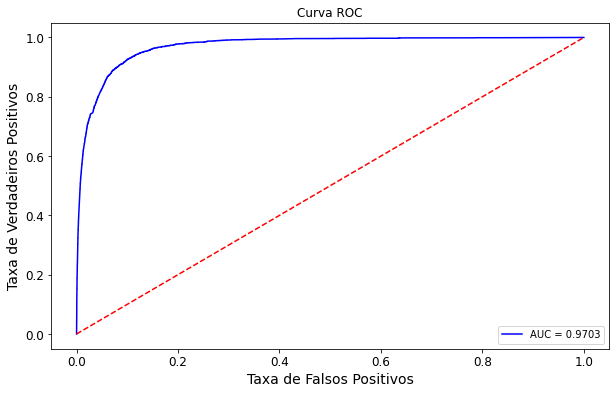

In [ ]:
import sklearn.metrics as metrics

probs = rfc.predict_proba(x_teste)
preds = probs[:,1]
fpr, vpr, threshold = metrics.roc_curve(y_teste, preds)
roc_auc = metrics.auc(fpr, vpr)

#--- Curva ROC + AUC

plt.figure(figsize = [10, 6])
plt.title("Curva ROC")
plt.plot(fpr, vpr, "blue", label = "AUC = %0.4f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("Taxa de Verdadeiros Positivos", fontsize = 14, color = "black")
plt.xlabel("Taxa de Falsos Positivos", fontsize = 14, color = "black")
plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")
plt.show()

# 9. Validação cruzada

---

- Com todos as análises de métricas, podemos confirmar nosso modelo é bom? Sim e não. Exatamente para aquela amostra que separamos de teste (que esperamos que seja representativa), sim ela foi muito boa;

- Mas e se quiséssemos testar para amostras diferentes ?

- Aí que entra a famosa Validação Cruzada, para verificar o desempenho do nosso modelo em diferentes cenários de dados de testes;

- Inicialmente indicamos em quantas $ k $ validações/divisões dos dados, queremos que o modelo seja treinado, na imagem abaixo temos $ k = 5 $;

- Em cada uma dessas $ k $ validações o nosso modelo será testado com dados de treino e teste diferentes, tanto é que você pode ver que em nenhum momento terá algum cenário em  que os dados de treino e teste se repetem, conforme a imagem abaixo;


<p align="center">
  <img src="https://miro.medium.com/max/1056/1*2fW8Y8gDEgUMIWO8z3-cLQ.png" alt="drawing" width="500" height="300"/>

Retirado de: https://medium.com/@joorge.lm/valida%C3%A7%C3%A3o-cruzada-cross-validation-avaliando-seu-modelo-de-forma-clara-e-concisa-10d27fa4efb8
</p>

- Para cada $ k $ validação, a RF será treinada e testada e nos dará algumas métricas de nossa escolha para verificarmos a legitimidade do nosso modelo;

- Ao final, podemos tirar uma média e verificar exatamente um número também;

- As métricas a ser monitoradas serão:

  - Recall;
  - ROC/AUC
  - F1;
  - Precision; e
  - Acurácia.

- Os parâmetros para a função `cross_validate` serão:

  - **Modelo**, nesse caso a RF;
  - **Dados de treino**;
  - **CV** ou o número de $ k $, na imagem foi 5 mas no nosso caso vamos utilizar somente 4;
  - Quais **métricas** você quer monitorar (pode ser somente uma também);
  - **n_jobs = -1** (não é obrigatório mas queremos que ele vá mais rápido).

- Podemos perceber, tanto pelo dicionário quanto pelo gráfico que nossas métricas são estáveis, significando que em diferentes cenários onde mudamos dados de treino e teste, ele também performou bem.

In [ ]:
from sklearn.model_selection import cross_validate 

scoring1 = ["recall", "roc_auc", "f1", "precision", "accuracy"]

scores = cross_validate(rfc, x_treino, y_treino, cv = 4, scoring = scoring1, n_jobs = -1)

scores

{'fit_time': array([205.57308459, 199.75539279, 191.58379269, 211.80464482]),
 'score_time': array([14.93432188, 14.95935774, 17.04701662,  7.99905491]),
 'test_accuracy': array([0.98542874, 0.98498524, 0.98523233, 0.98520525]),
 'test_f1': array([0.33682589, 0.33237995, 0.329748  , 0.34522026]),
 'test_precision': array([0.24213558, 0.23660523, 0.23676081, 0.24521073]),
 'test_recall': array([0.55313765, 0.55842185, 0.54301619, 0.58299595]),
 'test_roc_auc': array([0.96695164, 0.96079447, 0.96263566, 0.96148361])}

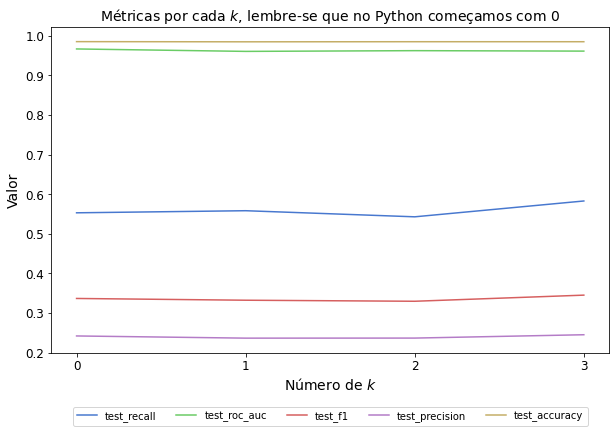

In [ ]:
import matplotlib.ticker as mticker

df_scores = pd.DataFrame(scores)

f = plt.figure()

df_scores.drop(["fit_time", "score_time"], axis = 1).plot(kind = "line", figsize = (10, 6), ax = f.gca())

plt.title("Métricas por cada $ k $, lembre-se que no Python começamos com 0", fontsize = 14, color = "black")
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncol = 5)
plt.xlabel("Número de $ k $", fontsize = 14, color = "black")
plt.ylabel("Valor", fontsize = 14, color = "black")
plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")
plt.xticks(rotation = 0)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.show()

# 10. Importância das variáveis

---

- O ranking abaixo é baseado na impureza. Pesquisando, li alguns casos em que devemos ter cuidado em usar este método (mais informações pode ser visto neste [post](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) e na [documentação](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) do `sklearn`);

- Podemos ver que as principais variáveis que o modelo considerou foi:

  - A que indica o nível de estoque da peça e o seu quadrado;
  - A previsão de vendas para o produto em i meses; $ i = 3, 6, 9 $;
  - Demais...

In [ ]:
pd.DataFrame(rfc.feature_importances_, x_teste.columns).reset_index().rename(columns = {0: "Valor", "index": "Variável"}).sort_values("Valor", ascending = False).round(5)

,Variável,Valor
0,national_inv,0.10581
3,forecast_3_month,0.10388
5,forecast_9_month,0.08497
4,forecast_6_month,0.08361
21,national_inv_poly2,0.08065
35,forecast_3_month_isesqual0,0.04819
9,sales_9_month,0.04272
7,sales_3_month,0.04153
8,sales_6_month,0.04048
14,perf_12_month_avg,0.03905


# Conclusões

---

- Criamos novas features baseadas na Análise Exploratória de Dados e em algumas interações que faziam sentido na cabeça do analista (eu);

- Em algumas delas utilizamos a técnica de One-Hot Encoding;

- Utilizamos um modelo de Random Forest, pois foi o que mais se adequou aos dados a partir das métricas que os demais;

- As demais tentativas com outros modelos estão no meu [github](https://github.com/barbosarafael/Projetos/tree/master/iNeuron_Back_order_prediction_Notebook), caso vocês queiram saber o resultado das outras também;

- Verificamos que a RF foi consistente em diferentes cenários de treino e teste utilizando a Validação Cruzada;

- Descobrimos quais as variâncias possuem mais importância no modelo.


# Referências 

---


## Random Forest

1. GRUS, J. Data Science do zero: Primeiras regras com o Python. Alta Books, 2019.
2. MORETTIN, P. A.; SINGER, J. M. Introdução a Ciência de Dados. Texto Preliminar, IME-USP, 2020.
3. FRIEDMAN, J; HASTIE, T; TIBSHIRANI, R. The elements of statistical learning. New York: Springer series in statistics, 2001.
4. https://medium.com/turing-talks/turing-talks-18-modelos-de-predi%C3%A7%C3%A3o-random-forest-cfc91cd8e524
5. http://carlosbaia.com/2016/12/24/decision-tree-e-random-forest/
6. https://medium.com/machina-sapiens/o-algoritmo-da-floresta-aleat%C3%B3ria-3545f6babdf8


## One Hot Encoding

1. https://minerandodados.com.br/one-hot-encoding-como-funciona-python/
2. https://medium.com/@arthurlambletvaz/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0
3. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/